In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


snippet for duration reporting

In [ ]:
timestamp_start = datetime.datetime.now()

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

# [ IMPORTS ]

In [ ]:
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import statistics as stats
import scipy.signal as scsig

import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# [ GLOBAL ]

In [ ]:
# Resample every signal to this rate for consistency
BASIC_SRATE = 128 #Hz
print('Basic sampling rate(Hz): '+str(BASIC_SRATE))


#=================================================
# working directories
#=================================================

# > _ base working directory
global_dir = '/content/drive/My Drive/Masters/workdir/ecg_data'
print('GLOBAL DIR :: '+global_dir)

# >> global MAT directory, contains signal data in matlab (.mat) format
global_matdir = os.path.join(global_dir, 'db_mat') 
print('GLOBAL MAT DIR :: '+global_matdir)

# >> global NPY directory, contains signal and meta data in numpy (.npy) format
global_npydir = os.path.join(global_dir, 'db_npy') 
print('GLOBAL NPY DIR :: '+global_npydir)

# >> global datasets directory, contains manually generated datasets
global_dsdir = os.path.join(global_dir, 'db_dataset') 
print('GLOBAL DATSET DIR :: '+global_dsdir)

# >> model directory, contains model weights and test results use load_weights(), save_weights() 
global_modeldir = os.path.join(global_dir, 'db_model')
print('GLOBAL MODEL DIR :: ' + global_modeldir)

#>>----------------------------------------------- 


#=================================================
# Annotations
#=================================================
# >> annotation directory, contains annotation mapping files to be used for experiments
global_antdir = os.path.join(global_dir, 'db_ant') 
print('GLOBAL ANNOTATION DIR :: ' + global_antdir)
#>>----------------------------------------------- 


#=================================================
# File Identifiers
#=================================================
# beat and non-beat annotations, signal data types to be used to save data in npy format
g_BA = 'BA'                     #<<--- beat annotations (@orignal Sampling rate)
g_NBA = 'NBA'                   #<<--- non-beat annotations (@orignal Sampling rate)
g_RAW2 = 'RAW2'                 #<<--- Raw lead2 signal from mat file
g_BLF2 = 'BLF2'                 #<<--- Baseline fitted signal
g_RES2 = 'RES2'                 #<<--- Resampled to BASIC_SRATE

g_SIG2 = 'SIG2'     #<<--- Removed manual gain
g_RPEAK = 'RRP'     #<<--- Resampled R-peaks
#>>----------------------------------------------- 

Basic sampling rate(Hz): 128
GLOBAL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data
GLOBAL MAT DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_mat
GLOBAL NPY DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy
GLOBAL DATSET DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
GLOBAL MODEL DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_model
GLOBAL ANNOTATION DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_ant


# [ CLASS DEFINITIONS ]

In [ ]:
#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_db : represents one ECG database
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_db:
    def __init__(self, dbname,  tag_recs):
        print('\nInitailze new ecg database ... ')
        self.name = dbname  #str
        self.dir_npy = os.path.join(global_npydir , dbname+'_npy') #str
        self.recs = set(np.loadtxt(os.path.join(self.dir_npy,'RECORDS'), dtype='str',delimiter="\n")) #set
        self.recs_tag = set(tag_recs)
        self.recs_dict = {} # initially empty, will be loaded on demand using function 'get_record'
        self.info()

    def info(self):
        print( 'DB NAME :: '+ self.name)
        print( 'DATA DIR :: ' + self.dir_npy )
        print( 'RECORDS :: [' +str(len(self.recs))+'] ' + str(self.recs) )
        print( 'TAG RECORDS :: [' +str(len(self.recs_tag))+'] ' + str(self.recs_tag))
        return 0

    def get_record(self,rec):
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]
    
    def get_random_record(self, recset):
        rec = random.choice(list(recset))
        if not (rec in self.recs_dict.keys()):
            self.recs_dict[rec] = ecg_record(self,rec)
        return self.recs_dict[rec]

#---------------------------------------------------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_record : represents one ECG Record in any database
#---------------------------------------------------------------------------------------------------------------------------------------------
g_SUPRESS_DATA_WARNING=False
class ecg_record:

    def __init__(self, db, recname):
        self.db = db                                # class:{ecg_db}    object this record belongs to
        self.rec = recname                          # string            name of this record
        self.name = db.name + '_'+ recname          # string            full name including db.name
        if not recname in db.recs:
            print('WARNING:: Record "'+ recname +'" not found in database '+ db.name )
        self.data_npy = {}                          # dict dict of data file content used in self.read_data_npy('key')
        self.data_temp = {}                          # dict dict of data file content used in self.read_data_temp('key')
        self.binfo = None                           # class binfo       

##<------------------------------------------------- get instance of binfo class
    def read_binfo(self):
        if self.binfo == None:
            self.binfo = ecg_binfo(self)
        return self.binfo

    def refresh_binfo(self):
        self.binfo = ecg_binfo(self)
        return self.binfo

##<------------------------------------------------- data reading for npydir
    def load_data(self, data_type):
        ipath = os.path.join(self.db.dir_npy, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_npy[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data(self, data_type):
        if data_type in self.data_npy.keys():
            return self.data_npy[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data(data_type)

##<------------------------------------------------- for tempdir
    def load_data_temp(self, data_type, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        try: # try to load this data
            self.data_temp[data_type] = np.load(ipath) # adds this to dictionary so next time it can read
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        except:
            if g_SUPRESS_DATA_WARNING == False:
                print('WARNING:: Cant load "'+data_type+ '" file at '+ str(ipath) )
            return np.array([])
        
    def read_data_temp(self, data_type, dir_path):
        if data_type in self.data_temp.keys():
            return self.data_temp[data_type] #= np.load(self.dirs[s])
        else:
            return self.load_data_temp(data_type, dir_path)

    def save_data_temp(self, data_type, data_array, dir_path):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        np.save(ipath, data_array)
        return ipath

    def del_data_temp(self, data_type, dir_path, vb):
        ipath = os.path.join(dir_path, self.rec + '_'+data_type+'.npy')
        if os.path.exists(ipath):
            if vb:
                print('Removing: '+str(ipath))
            os.remove(ipath)
            return 1
        else:
            return 0
#------------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------------------------------------------------------
# CLASS ecg_binfo : information about beats in a record
#---------------------------------------------------------------------------------------------------------------------------------------------
class ecg_binfo:
    def __init__(self, rec):
         
        # the record object
        self.rec = rec
        
        # read orignal annotations
        r_peaks_ants = rec.read_data(g_RPEAK)       # resampled ant file
        
        # calculate count of R peaks (excluding first and last)
        self.rp_count = len(r_peaks_ants) - 2
        
        # Extract Location and Labels of Peaks (exclude first and last beat)
        r_peaks_int = r_peaks_ants[:,0].astype('int')
        r_ants_str = r_peaks_ants[:,1]
        
        #self.rp_first = r_peaks_int_raw[0] # = self.rp_prev[0]
        #self.rp_last = r_peaks_int_raw[-1] # = self.rp_next[-1]
        
        # Location
        self.rp_curr = r_peaks_int[1:-1]    # current R peak
        self.rp_prev = r_peaks_int[0:-2]    # previous R peak (in samples)
        self.rp_next = r_peaks_int[2:]      # next R peak (in samples)
        
        # Label
        self.rl_curr = r_ants_str[1:-1]
        self.rl_prev = r_ants_str[0:-2]
        self.rl_next = r_ants_str[2:]

        # mapped Label
        self.rli_prev = []
        self.rli_curr = []
        self.rli_next = []

        # calculate temporal info
        self.rp_sec = self.rp_curr / BASIC_SRATE                 # peak location (in sec)
        self.rri_prev = (self.rp_curr - self.rp_prev) / BASIC_SRATE   # prev RRI (in sec) 
        self.rri_next = (self.rp_next - self.rp_curr) / BASIC_SRATE   # next RRI (in sec) 
        self.rri_delta = (self.rri_next - self.rri_prev)              # difference b/w prev and next RRI (in sec) 
        self.rri_dur = (self.rri_next + self.rri_prev)                # total duration from prev to next R-peak
        

    def get_signal_data_var(self, ith_peak): # data_type = g_SIG_II_POSTFIX
        # prev peak to next peak
        sel_sig = self.rec.read_data(g_SIG2) 
        ff = self.rp_prev[ith_peak]
        tt = self.rp_next[ith_peak]
        pp = self.rp_curr[ith_peak]
        sel_part = sel_sig[ff:tt+1]
        return sel_part, (pp-ff), (tt+1-ff) #<- also return position of peak
    
    def get_signal_data_fix(self, ith_peak, v_left_sec, v_right_sec): # data_type = g_SIG_II_POSTFIX
        return self.get_signal_data_fix_samples(ith_peak,int(v_left_sec*BASIC_SRATE),int(v_right_sec*BASIC_SRATE))

    def get_signal_data_fix_samples(self, ith_peak, v_left, v_right): # data_type = g_SIG_II_POSTFIX
        sel_sig = self.rec.read_data(g_SIG2) 
        ff = self.rp_curr[ith_peak]-v_left
        tt = self.rp_curr[ith_peak]+v_right
        pp = self.rp_curr[ith_peak]

        f_pad,t_pad=0,0
        if ff<0:
            f_pad=0-ff
            ff=0

        if tt>len(sel_sig):
            tpad=tt-len(sel_sig)
            tt=len(sel_sig)

        sel_part = np.hstack((
            np.zeros(f_pad),
            sel_sig[ff:tt],
            np.zeros(t_pad),
            ))

        pl = pp+f_pad
        return sel_part, pl #<- also return position of peak

    def get_local_hrT(self,local_window_start,local_window_end): # within a time duration
        lws = local_window_start*BASIC_SRATE # in samples        
        lwe = local_window_end*BASIC_SRATE # in samples        
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        ff = max( lws ,self.rp_prev[0])
        tt = min( lwe ,self.rp_next[-1])
        dd = (tt-ff)/BASIC_SRATE
        qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
        nq = len(qq)# qq must be at least 2 peaks
        # if qq peaks in dd secs then heart rate = (qq/dd) bps =  (qq/dd)*60 bpm
        if nq<2:  
             dd=0
             local_bps = 0
        else:
             ff = self.rp_curr[qq[0]]
             tt = self.rp_curr[qq[-1]]
             dd = (tt-ff)/BASIC_SRATE
             local_bps = (nq-1)/dd #bps
        
        return local_bps, dd
   
     
    def get_local_hr(self,ith_peak, local_window_left,local_window_right): # within local duration of ith peak
        lwl = local_window_left*BASIC_SRATE # in samples        
        lwr = local_window_right*BASIC_SRATE # in samples        
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        ff = max(self.rp_curr[ith_peak] - lwl ,self.rp_prev[0])
        tt = min(self.rp_curr[ith_peak] + lwr ,self.rp_next[-1])
        
        qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
        nq = len(qq)# qq must be at least 2 peaks
        if nq<2:  
             return 0, 0
        else:
             ff = self.rp_curr[qq[0]]
             tt = self.rp_curr[qq[-1]]
             dd = (tt-ff)/BASIC_SRATE
        # if nq peaks in dd secs then heart rate = (nq/dd) bps =  (nq/dd)*60 bpm
             local_bps = (nq-1)/dd #bps
             return local_bps, dd

    def get_local_hrA(self, local_window_left,local_window_right): # within local duration of all peaks
        lwl = local_window_left*BASIC_SRATE # in samples        
        lwr = local_window_right*BASIC_SRATE # in samples       
        #ff and tt should be within signal limits
        # if not in limits then take shortest : means truncate lw duration
        local_bps = np.zeros(self.rp_count,dtype='float')
        local_dd = np.zeros(self.rp_count,dtype='float')
        for ith_peak in range(0, self.rp_count):
             ff = max(self.rp_curr[ith_peak] - lwl ,self.rp_prev[0])
             tt = min(self.rp_curr[ith_peak] + lwr ,self.rp_next[-1])
             qq = np.where((self.rp_curr>=ff) & (self.rp_curr<=tt))[0] #  these many peaks in dd sec
             nq = len(qq) # qq must be at least 2 peaks
             if nq<2:  
                  local_bps[ith_peak] = 0 #bps
                  local_dd[ith_peak] = 0 #bps
             else:
                  ff = self.rp_curr[qq[0]]
                  tt = self.rp_curr[qq[-1]]
                  dd = (tt-ff)/BASIC_SRATE
                  local_bps[ith_peak] = (nq-1)/dd #bps
                  local_dd[ith_peak] = dd #bps
        return local_bps, local_dd
    
    def map_ants2int(self,map_dict):
        if len(self.rli_curr)!=self.rp_count:
            temp = np.zeros(self.rp_count+2,dtype='str')
            temp[0] =  map_dict[self.rl_prev[0]]
            for i in range(0, self.rp_count):
                temp[i+1] = map_dict[self.rl_curr[i]]
            temp[-1] =  map_dict[self.rl_next[-1]]
            self.rli_curr = temp[1:-1]
            self.rli_prev = temp[0:-2]
            self.rli_next = temp[2:]


class data_params():
    def __init__ (self, input_type, fL, fR, vdim_sec, peak_ratio, pad_value, suppress_len):
        self.input_type = input_type
        self.pad_value = pad_value
        self.suppress_peak_len = suppress_len
        if input_type=='var':
            # define vdim and peak ratio, pad, supress_len
            self.vdim = vdim_sec*BASIC_SRATE
            self.peak_ratio = peak_ratio
            # calculate rest
            self.fix_left = int(self.vdim*self.peak_ratio)
            self.fix_right = self.vdim-self.fix_left

        elif input_type=='fix':
            # define left and right samples
            self.fix_left = int(fL*BASIC_SRATE)
            self.fix_right = int(fR*BASIC_SRATE)
            # calculate rest
            self.vdim = self.fix_left + self.fix_right
            self.peak_ratio = self.fix_left/self.vdim
        else:
            print('Invalid Input Type')

        print('Input Type:', self.input_type)
        print('Vector Dimension:', self.vdim)
        print('Peak Ratio:', self.peak_ratio, '[',self.fix_left,',',self.fix_right,']')
        print('Padding Value:', self.pad_value)
        print('Suppress Peaks:', self.suppress_peak_len)

# [ BUILD STANDARD DBs ]

In [ ]:
print('Buidling standard databases')
#------------------------------------------------------------------------
std_mitdb = ecg_db('mitdb', [])
#------------------------------------------------------------------------
std_svdb = ecg_db('svdb', [])
#------------------------------------------------------------------------
std_incartdb= ecg_db('incartdb', [])
#------------------------------------------------------------------------

Buidling standard databases

Initailze new ecg database ... 
DB NAME :: mitdb
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/mitdb_npy
RECORDS :: [48] {'219', '210', '122', '208', '213', '222', '124', '200', '212', '217', '115', '112', '202', '123', '228', '111', '107', '232', '114', '231', '201', '105', '109', '119', '230', '223', '117', '108', '233', '104', '214', '118', '116', '207', '121', '209', '101', '113', '220', '234', '205', '103', '100', '221', '102', '215', '106', '203'}
TAG RECORDS :: [0] set()

Initailze new ecg database ... 
DB NAME :: svdb
DATA DIR :: /content/drive/My Drive/Masters/workdir/ecg_data/db_npy/svdb_npy
RECORDS :: [78] {'871', '829', '826', '857', '854', '802', '844', '809', '804', '875', '867', '842', '810', '845', '824', '858', '880', '820', '843', '868', '850', '873', '856', '870', '890', '882', '872', '855', '823', '884', '847', '866', '846', '879', '861', '865', '885', '886', '825', '828', '853', '891', '822', '851', '888', '892', '

# [ PERFORMANCE MEASURES ]

In [ ]:
#=========================================================================================================================
#======================= NEURAL NETWORK PERFORMANCE MEASURES
#=========================================================================================================================
# 3.3 :: define performance evaluation functions

def get_performance(conf_matrix):
    #how many classes? = len of conf_matril
    nos_class = len(conf_matrix[0,:]) # len of 0th row
    res = np.zeros((0,8),dtype ='float64')
    for i in range(0,nos_class):
        # for each class calculate 4 performance measure - ACC, PRE, SEN, SPF, 
        # first compute TP, TN, FP, FN
        TP = conf_matrix[i,i]
        FP = np.sum(conf_matrix[:,i]) - TP
        FN = np.sum(conf_matrix[i,:]) - TP
        TN = np.sum(conf_matrix) - FN - FP - TP

        ACC = (TP+TN)   /   (TP+FP+FN+TN)
        PRE = (TP)      /   (TP+FP)
        SEN = (TP)      /   (TP+FN)
        SPF = (TN)      /   (TN+FP)

        res_i = np.array([TP, FN, FP, TN, ACC, PRE, SEN, SPF])
        res = np.vstack((res,res_i))
    return res


#------------------------------------------------------------------PRINTING

def print_lstr(class_labels):
    g_LSTR=''   # HEADER ROW for printing confusing matrix
    for i in range(0,len(class_labels)):
        g_LSTR+='\t'+str(class_labels[i])
    return  g_LSTR

def print_cf_row(cf_row,nos_labels):
    res = ''
    for j in range(0,nos_labels):
        res += '\t'+ str(cf_row[j])
    return res
def print_conf_matrix(conf_matrix, suffix, class_labels):
    res=(suffix+'A\\P' + print_lstr(class_labels)+'\n')
    nos_l=len(class_labels)
    for i in range(0,nos_l):
        res+=(suffix+str(class_labels[i]) + print_cf_row(conf_matrix[i],nos_l )+'\n')
    return res
def print_performance(perf_measures, class_labels):
    nos_class = len(perf_measures[:,0])
    print('Performance for '+str(nos_class)+' classes')
    print ('Class\tACC\tPRE\tSEN\tSPF')
    for i in range(0, nos_class):
        perf_i = np.round(perf_measures [i,:],2)
        #print('\tT.P : '+str(perf_i[0])+'\tF.N : '+str(perf_i[1]))
        #print('\tF.P : '+str(perf_i[2])+'\tT.N : '+str(perf_i[3]))
        print(str(class_labels[i])+'\t'+str(perf_i[4])+'\t'+str(perf_i[5])+'\t'+str(perf_i[6])+'\t'+str(perf_i[7]))
    return
#------------------------------------------------------------------

def plot_ecg_segment(signal_info, signal_array, fsec, tsec, x_scale, y_scale, y_low, y_high, mticks_pos, show_rris, predx, predy, predNoN, a_color, a_marker, gain=1):
    # plot signal segments
    #<<---------------------------------------------Select ECG Segment
    dsec = tsec - fsec
    print(signal_info.rec.name)
    if len(signal_array)==0:
        print('WARNING::Signal was not loaded.')
        return 0
    else:
        ff = int(fsec * BASIC_SRATE)
        tt = int(tsec * BASIC_SRATE)
        dd = tt - ff

        bps = signal_array[ff:tt] * gain  # signal data * gain
        lim_query = np.where((signal_info.rp_sec >= fsec) & (signal_info.rp_sec < tsec))[0]
        
        dticks = signal_info.rp_curr[lim_query]-ff  # tick position
        nos_ticks = len(dticks)
        sc_zero = np.zeros(nos_ticks)

        dlabels = signal_info.rl_curr[lim_query]    # orignal labels
        dilabels = signal_info.rli_curr[lim_query]  # mapped labels

        dicolors = np.zeros(nos_ticks, dtype='U15') # get color repesentation
        for i in range(0,nos_ticks):
            dicolors[i]= g_STD_LABELS[dilabels[i]]

        print('Time Interval{'+str(dsec)+'s}:['+str(fsec)+':'+str(tsec)+']')
        if nos_ticks > 0:
            print('Beat Interval{'+str(nos_ticks)+'#}:['+str(lim_query[0])+':'+str(lim_query[-1])+']')
        else:
            print('Beat Interval{'+str(nos_ticks)+'#}')

        
 
        #<<---------------------------------------------Prepare Prediction
        #predx = [cmx2_localS,cmx2_localV,cmx2_localA]
        #predy = [datayS,datayV,datayA]
        diPredColL = []
        for i in range(0,len(a_color)):
            dpredx = predx[i][lim_query]
            
            diPredCol = np.zeros(nos_ticks, dtype='U15') 
            for j in range(0,nos_ticks):
                if dpredx[j]==0:
                    diPredCol[j]= 'tab:green'      
                else:
                    diPredCol[j]= a_color[i]
            diPredColL.append(diPredCol)

       # prepare figure: signal
        plt.figure('ecg signal', figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
        plt.xlim(0, len(bps))
        plt.ylim(y_low,y_high)
        plt.yticks([])
        plt.xticks(dticks,dlabels)
        #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
        #plt.xticks(x_grid)
        plt.grid(axis='x')
        # plot signal and baseline
        plt.plot(bps, linewidth=0.5, color='black')
        plt.hlines(0,0,len(bps), linewidth=0.3)
        # plot mapped labels
        plt.scatter(dticks,sc_zero+mticks_pos,marker='s',color=dicolors)
        plt.scatter(dticks,sc_zero-mticks_pos,marker='o',color=diPredColL[-1])
        # finalize
        plt.tight_layout()
        plt.show()        

        # prepare figure: predictions
        plt.figure('ecg predictions', figsize = (dsec*x_scale ,(y_high-y_low) * y_scale) )
        plt.xlim(0, len(bps))
        plt.ylim(0,1.5)
        plt.yticks([])
        plt.xticks(dticks,dlabels)
        plt.grid(axis='x')
        #plt.hlines(0,0,len(bps), linewidth=0.3)
        #plt.hlines(0.5,0,len(bps), linewidth=0.3)
        #plt.hlines(1,0,len(bps), linewidth=0.3)
        plt.scatter(dticks,sc_zero+0.1,marker='s',color=dicolors)

        for i in range(0,len(a_color)):
            plt.scatter(dticks,sc_zero+0.1+(0.30*(i+1)),marker=a_marker[i],color=diPredColL[i])

        '''
        pred_str = np.zeros(len(diPred))
        for i in range(0,len(diPred)):
            pred_str[i]=dpredx[i][diPred[i]]
            
        plt.scatter(dticks,pred_str,marker='.',color='black')
        '''

        ditruth = predy[-1][lim_query]
        ditrutho = predNoN[lim_query]
        diPred = predx[-1][lim_query]
        # where predy is 0 and predx is 1
        d_aN_pA = dticks[np.where((ditruth==0)&(diPred==1))[0]]
        d_aN_pAo = dticks[np.where((ditrutho==0)&(diPred==1))[0]]
        plt.scatter(d_aN_pA,np.zeros(len(d_aN_pA))+1.2,marker='x',color='tab:green')
        plt.scatter(d_aN_pAo,np.zeros(len(d_aN_pAo))+1.4,marker='+',color='tab:green')

        d_aA_pN = dticks[np.where((ditruth==1)&(diPred==0))[0]]
        d_aA_pNo = dticks[np.where((ditrutho==1)&(diPred==0))[0]]
        plt.scatter(d_aA_pN,np.zeros(len(d_aA_pN))+1.2,marker='x',color='tab:orange')
        plt.scatter(d_aA_pNo,np.zeros(len(d_aA_pNo))+1.4,marker='+',color='tab:orange')
        '''
        #plt.scatter(dticks,dpredx[:,0],marker='x',color='tab:green')
        #plt.scatter(dticks,dpredx[:,1],marker='x',color=a_color)
        '''
        plt.tight_layout()
        plt.show()
        

        
        
        if show_rris:
             ddur = signal_info.rri_dur[lim_query]       # duration
             ddel = np.absolute(signal_info.rri_delta[lim_query] )      # delta rri
             # prepare figure: rri,delta rri
             my_low, my_high = -0.1, 3.5
             plt.figure('ecg meta', figsize = (dsec*x_scale ,(my_high-my_low) * 1.5*y_scale) )
             plt.xlim(0, len(bps))
             plt.ylim(my_low,my_high)
             plt.yticks([])
             plt.xticks(dticks,dlabels)
             #x_grid = np.arange(0,tt-ff, 1*BASIC_SRATE)
             #plt.xticks(x_grid)
             plt.grid(axis='x')
     
             # plot grid and baseline
             plt.hlines(0,0,len(bps), linewidth=0.3,color='red')
             #for j in [0.5,1,1.5,2,2.5,3]:
             #    plt.hlines(j,0,len(bps), linewidth=0.3,color='black')
     
             # plot mapped labels
             plt.scatter(dticks,ddur,marker='s',color=dicolors)
             plt.scatter(dticks,ddel,marker='o',color='tab:purple')
             plt.plot(dticks,ddur,color='black',linewidth=0.5,linestyle='dotted')
             plt.plot(dticks,ddel,color='black',linewidth=0.5,linestyle='dotted')
             # finalize
             plt.tight_layout()
             plt.show()

        return bps,dticks,dlabels





---

END OF SHARED SECTION

---



# [ EXP DATA DICT ]

In [ ]:
mitdb_ex = set([
            '102','104','107','217', # paced
            '207',   # VFlutter
            '212', '231',   # both N and BBB
            '108', # bad signal
            '202','203' # bad labeling
            ])
svdb_ex = set([])
incartdb_ex = set([])

#<<--------------------------------------------
std_mitdb.recs_tag = set.difference(std_mitdb.recs, mitdb_ex)
std_svdb.recs_tag = set.difference(std_svdb.recs, svdb_ex)
std_incartdb.recs_tag = set.difference(std_incartdb.recs, incartdb_ex)

#<<--------------------------------------------
std_db_msi = {}
std_db_msi['mitdb']=std_mitdb
std_db_msi['svdb']=std_svdb
std_db_msi['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_ms = {}
std_db_ms['mitdb']=std_mitdb
std_db_ms['svdb']=std_svdb

#<<--------------------------------------------
std_db_mi = {}
std_db_mi['mitdb']=std_mitdb
std_db_mi['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_si = {}
std_db_si['svdb']=std_svdb
std_db_si['incartdb']=std_incartdb

#<<--------------------------------------------
std_db_m = {}
std_db_m['mitdb']=std_mitdb

#<<--------------------------------------------
std_db_s = {}
std_db_s['svdb']=std_svdb

#<<--------------------------------------------
std_db_i = {}
std_db_i['incartdb']=std_incartdb



# [ --- EXP_3 : multiple --- ]

This experiment classifies beats into Normal or Abnormal category. Annotations used are N,S,V (F beats are included in V type) using CNN and variable beat length padded or truncated appropiately

# [ VIEW ANNOTATION MAPPERS ]

In [ ]:
ls_ants = os.listdir(global_antdir)
ls_ants=np.sort(ls_ants)
print('Available annotation files ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

# [ MAP ANNOTATIONS ]

In [ ]:
# standard labels and mappings default_labels
sel_labels = os.path.join(global_antdir, 'nsv_labels.txt') 
sel_map = os.path.join(global_antdir, 'nsv_map.txt') 

# ----------------------------------------------------------------------
# ------ load standard labels ------------------------------------------
# ----------------------------------------------------------------------
sel_labels_data = np.loadtxt(sel_labels, dtype='str',delimiter="\t")
g_STD_LABELS={}
print('\nStandard Labels::')
for a in sel_labels_data:
    # a[0] =  # standard label (char)
    # a[1] =  # mapped color (str)
    # a[2]  = # description (str)
    g_STD_LABELS[a[0]]= a[1]
    print(a[0]+'\t'+a[1]+'\t'+a[2])

# ----------------------------------------------------------------------
# ------ load mapping data ---------------------------------------------
# ----------------------------------------------------------------------
ant_map_data = np.loadtxt(sel_map, dtype='str',delimiter="\t")
g_STD_NO_MAP = '_'
g_STD_LABELS[g_STD_NO_MAP]='black'
g_STD_MAP={}
print('\nMapping::')
for a in ant_map_data:
    # a[0] =  # orignal pysionet label (char)
    # a[1] =  # mapped standard label (char)
    # a[2]  = # description (str)
    g_STD_MAP[a[0]]= a[1] ##<<----------------mapping dictionary
    print(a[0]+'\t'+a[1]+'\t'+a[2])
print('\n',g_STD_MAP.keys())

#<<--------------------------------------------

for idb in std_db_msi.keys():
    sel_db = std_db_msi[idb]
    for irec in sel_db.recs_tag:
        sel_rec = sel_db.get_record(irec)
        sel_info = sel_rec.read_binfo()
        sel_info.map_ants2int(g_STD_MAP)



Standard Labels::
N	green	Normal
S	red	Supraventricular Premature
V	blue	Ventricular Premature

Mapping::
N	N	Normal beat
L	N	Left bundle branch block beat
R	N	Right bundle branch block beat
B	N	Bundle branch block beat (unspecified)
A	S	Atrial premature beat
a	S	Aberrated atrial premature beat
J	S	Nodal (junctional) premature beat
S	S	Supraventricular premature or ectopic beat (atrial or nodal)
V	V	Premature ventricular contraction
r	V	R-on-T premature ventricular contraction
F	V	Fusion of ventricular and normal beat
e	_	Atrial escape beat
j	_	Nodal (junctional) escape beat
n	_	Supraventricular escape beat (atrial or nodal)
E	_	Ventricular escape beat
/	_	Paced beat
f	_	Fusion of paced and normal beat
Q	_	Unclassifiable 
?	_	Beat not classified during learning
[	_	Start of ventricular flutter/fibrillation
!	_	Ventricular flutter wave
]	_	End of ventricular flutter/fibrillation
x	_	Non-conducted P-wave (blocked APC)
(	_	Waveform onset
)	_	Waveform end
p	_	Peak of P-wave
t	_	Peak of T-

# [ PARAMS ]

In [ ]:
N_Label, S_Label, V_Label, A_Label  = 'N', 'S', 'V', 'A'
gS_LABELS, gV_LABELS, gA_LABELS = [N_Label,S_Label], [N_Label,V_Label], [N_Label,A_Label]
# data_params('fix/var', fL, fR, vdim_sec, peak_ratio, pad_value, suppress_len) 
print('\nS-Params')
#S_DP = data_params('fix', 0.4, 0.1, None, None, 0, 0)
S_DP = data_params('var', None, None, 3, 0.85, 0, 12)
print('\nV-Params')
#V_DP = data_params('var', None, None, 3, 0.85, 0, 12)
V_DP = data_params('var', None, None, 3, 0.10, 0, 24)


S-Params
Input Type: var
Vector Dimension: 384
Peak Ratio: 0.85 [ 326 , 58 ]
Padding Value: 0
Suppress Peaks: 12

V-Params
Input Type: var
Vector Dimension: 384
Peak Ratio: 0.1 [ 38 , 346 ]
Padding Value: 0
Suppress Peaks: 24


# [ MODEL ]

In [ ]:
cb_esr = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy', 
        min_delta=0.00001, 
        patience=2, 
        verbose=0, 
        mode='auto', 
        baseline=None, 
        restore_best_weights=False)
cb_listr=[cb_esr] 
cost = 'sparse_categorical_crossentropy'
opt = 'rmsprop'

def get_modelCNN_2(print_summary, vdims):
    #itempo = Input( shape=(7,), name = "input_tempo" )
# NORM INPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

    inorm = Input( shape=(vdims,2), name = "input_norm" )

    conv_inorm_1 =  Conv1D(64,                #filters, 
                          7,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_1') (inorm) 
    
    #maxpool_icompar_2 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_1)
    
    conv_inorm_3 =  Conv1D(40,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_3')(conv_inorm_1) #(maxpool_icompar_2)
    
    #maxpool_icompar_4 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_3)
    conv_inorm_5 =  Conv1D(20,                #filters, 
                          3,                  #kernel_size, 
                          strides=1, 
                          padding='valid', 
                          data_format='channels_last', 
                          dilation_rate=1, 
                          activation=tf.nn.leaky_relu, 
                          use_bias=True, 
                          kernel_initializer='glorot_uniform', 
                          bias_initializer='zeros', 
                          kernel_regularizer=None, 
                          bias_regularizer=None, 
                          activity_regularizer=None, 
                          kernel_constraint=None, 
                          bias_constraint=None,
                          name='conv_inorm_5') (conv_inorm_3)#(maxpool_icompar_4)
    
    #maxpool_icompar_6 = MaxPooling1D(pool_size=2, 
    #                              strides=None, 
    #                              padding='valid', 
    #                              data_format='channels_last') (conv_icompar_5)
    
    flat_inorm_7 = Flatten(data_format=None,name='flat_inorm_7') (conv_inorm_5) #(maxpool_icompar_6)
    

# DENSE SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    
    den_fc0 = Dense(40, activation=tf.nn.relu, name = "DENSE_FC0")(flat_inorm_7)
    
    den_fc1 = Dense(20, activation=tf.nn.relu, name = "DENSE_FC1")(den_fc0)

# OUTPUT SIDE ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    den_out = Dense(2, activation=tf.nn.softmax, name = "OUTPUT_FC")(den_fc1)

# =========================================================================================
    model=Model(inputs=inorm, outputs=den_out)
    #-------------------------------------
    #model.get_layer(name="LSTM_50").trainable=is_trainable
    #-------------------------------------
    model.compile(loss=cost, optimizer=opt, metrics=['accuracy'])
    if print_summary:
        print(model.summary())
    return model


In [ ]:
test = get_modelCNN_2(True,3*BASIC_SRATE)

Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_norm (InputLayer)      [(None, 384, 2)]          0         
_________________________________________________________________
conv_inorm_1 (Conv1D)        (None, 378, 64)           960       
_________________________________________________________________
conv_inorm_3 (Conv1D)        (None, 376, 40)           7720      
_________________________________________________________________
conv_inorm_5 (Conv1D)        (None, 374, 20)           2420      
_________________________________________________________________
flat_inorm_7 (Flatten)       (None, 7480)              0         
_________________________________________________________________
DENSE_FC0 (Dense)            (None, 40)                299240    
_________________________________________________________________
DENSE_FC1 (Dense)            (None, 20)                820

# [ DATASET GENRATING FUNCTIONS ]

In [ ]:
def repeat_array(A, max_len, shuffle):
    lenA = len(A)
    if lenA==0:
        return A
    if lenA>=max_len:
        a = np.random.choice(A, size=max_len, replace=False, p=None)
    else:
        req_n = max_len - lenA
        req_m = int(req_n/lenA)
        req_r = req_n % lenA
        a = np.random.choice(A, size=req_r, replace=False, p=None)
        for i in range(0,req_m+1):
            a = np.hstack((a,A))
    for i in range(0,shuffle):
        np.random.shuffle(a)
    return a
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------

def get_normal_selection_train(binfo, selc, NR_statergy, NC_statergy, shuffle):
    nnn_q = np.where(((binfo.rli_prev==N_Label)&(binfo.rli_curr==N_Label)&(binfo.rli_next==N_Label)))[0]
    ana_q = np.where((((binfo.rli_prev!=N_Label)|(binfo.rli_next!=N_Label)) & (binfo.rli_curr==N_Label)))[0]
    n_q= np.where(binfo.rli_curr==N_Label)[0]

    nnn_c = len(nnn_q)
    ana_c = len(ana_q)
    n_c = len(n_q)
    #if nnn_c + ana_c != n_c:
        #print('\nmismatch\n')
    selF = int(selc/2)
    selL = selc - selF

    rN3 = int(selc*nnn_c/n_c) 
    rNA = selc - rN3
    
    #print(nnn_c,ana_c,n_c)


    if NR_statergy == 'pure':
        nr_ind = repeat_array(nnn_q,selc,shuffle)  
    elif NR_statergy == 'semi':
        nr_ind = np.hstack((repeat_array(nnn_q,selF,shuffle),repeat_array(ana_q,selL,shuffle)))
    elif NR_statergy == 'dynamic':
        nr_ind = np.hstack((repeat_array(nnn_q,rN3,shuffle),repeat_array(ana_q,rNA,shuffle)))
    elif NR_statergy == 'random':
        nr_ind = repeat_array(n_q,selc,shuffle)
    else:
        print('Invalid NR_Statergy')
        nr_ind = np.array([0])

    if NC_statergy == 'pure':
        nc_ind = repeat_array(nnn_q,selc,shuffle)  
    elif NC_statergy == 'semi':
        nc_ind = np.hstack((repeat_array(nnn_q,selF,shuffle),repeat_array(ana_q,selL,shuffle)))
    elif NC_statergy == 'dynamic':
        nc_ind = np.hstack((repeat_array(nnn_q,rN3,shuffle),repeat_array(ana_q,rNA,shuffle)))
    elif NC_statergy == 'random':
        nc_ind = repeat_array(n_q,selc,shuffle)
    else:
        print('Invalid NC_Statergy')
        nc_ind = np.array([0])

    
    return nr_ind, nc_ind
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------


def generate_dataset_train(work_db, ex_limL, ex_limU, rli_ALabel,  NR_statergy, NC_statergy, shuffle ):
    nos_records=[]
    ds_selected = np.zeros((0,5), dtype='U10') # [db,rec,nr,c]
    for idb in work_db.keys():
        #<<--------------------
        sel_db = work_db[idb]
        for irec in sel_db.recs_tag:
            #<<--------------------
            sel_rec = sel_db.get_record(irec)
            #print('\n'+sel_rec.name)
            sbi = sel_rec.read_binfo()

            # find out all Abnormal beats
            a_query = ((sbi.rli_curr==rli_ALabel))
            a_indices = np.where(a_query)[0]
            a_count = len(a_indices)
            # limit A-type beats
            sela = 0
            if a_count<ex_limL:
                sela=0
            elif a_count>ex_limU:
                sela=ex_limU
            else:
                sela=a_count
    #<<-----------------------------------------------
            if sela==0:
                #print(sel_rec.name, '_')
                continue
    #<<-----------------------------------------------
            nr_indices, nc_indices = get_normal_selection_train(sbi, sela,  NR_statergy, NC_statergy, shuffle)
            nr_count = len(nr_indices)
            nc_count = len(nc_indices)
            if nr_count!=nc_count:
                print('Error: count NR-NC mismatch for ', sel_rec.name, nr_count,nc_count, '..skip')
                continue


            nos_records.append(sel_rec.name)    
            for i in range(0,sela):
                tn = np.array([idb,irec,str(nr_indices[i]),str(nc_indices[i]),'0'])
                ta = np.array([idb,irec,str(nr_indices[i]),str(a_indices[i]),'1'])
                ds_selected = np.vstack((ds_selected,tn,ta))
    return ds_selected, nos_records
#<<-----------------------------------------------#<<-----------------------------------------------
#<<-----------------------------------------------#<<-----------------------------------------------


def get_normal_selection_test(binfo, selc, NR_statergy, shuffle, TS_low, TS_high):
    nnn_q = np.where(((binfo.rli_prev==N_Label)&(binfo.rli_curr==N_Label)&(binfo.rli_next==N_Label)
    &(binfo.rp_sec>=TS_low)&(binfo.rp_sec<TS_high)))[0]
    ana_q = np.where((((binfo.rli_prev!=N_Label)|(binfo.rli_next!=N_Label)) & (binfo.rli_curr==N_Label)
    &(binfo.rp_sec>=TS_low)&(binfo.rp_sec<TS_high)))[0]
    n_q = np.where((binfo.rli_curr==N_Label)
    &(binfo.rp_sec>=TS_low)&(binfo.rp_sec<TS_high))[0]

    nnn_c = len(nnn_q)
    ana_c = len(ana_q)
    n_c = len(n_q)

    selF = int(selc/2)
    selL = selc - selF

    rN3 = int(selc*nnn_c/n_c) 
    rNA = selc - rN3

    if NR_statergy == 'pure':
        nr_ind = repeat_array(nnn_q,selc,shuffle)  
    elif NR_statergy == 'semi':
        nr_ind = np.hstack((repeat_array(nnn_q,selF,shuffle),repeat_array(ana_q,selL,shuffle)))
    elif NR_statergy == 'dynamic':
        nr_ind = np.hstack((repeat_array(nnn_q,rN3,shuffle),repeat_array(ana_q,rNA,shuffle)))
    elif NR_statergy == 'random':
        nr_ind = repeat_array(n_q,selc,shuffle)
    else:
        print('Invalid NR_Statergy')
        nr_ind = np.array([0])

    
    return nr_ind

def load_beat_segment2(ds_str, work_db, dparam, supress_NR=False): # string list of samples as input ('databse','record','NR','CR', 'Label')
    
    ds_selected = np.zeros((0,dparam.vdim,2),dtype='float')
    #ds_selectedL = np.zeros((0),dtype='float')
    if dparam.input_type == 'fix':
        for i in range(0,len(ds_str)):
            d = ds_str[i]
            d_db = d[0]
            d_rec = d[1]
            d_NRi = int(d[2])
            d_CRi = int(d[3])
            #d_L = np.array([int(d[4])])

            sel_rec = work_db[d_db].get_record(d_rec)
            sel_info = sel_rec.read_binfo()
            if supress_NR:
                d_NR = np.zeros(dparam.vdim)
            else:
                d_NR,_ = sel_info.get_signal_data_fix_samples(d_NRi,dparam.fix_left,dparam.fix_right)
                
            d_CR,_ = sel_info.get_signal_data_fix_samples(d_CRi,dparam.fix_left,dparam.fix_right)
            d_data = np.expand_dims(np.transpose(np.vstack((
                d_NR,
                d_CR
            ))),axis=0)
            ds_selected = np.vstack((ds_selected,d_data))

    elif dparam.input_type == 'var':
        for i in range(0,len(ds_str)):
            d = ds_str[i]
            d_db = d[0]
            d_rec = d[1]
            d_NRi = int(d[2])
            d_CRi = int(d[3])
            #d_L = np.array([int(d[4])])

            sel_rec = work_db[d_db].get_record(d_rec)
            sel_info = sel_rec.read_binfo()

            if supress_NR:
                d_NR = np.zeros(dparam.vdim)
            else:
                d_NR,dpk,_=sel_info.get_signal_data_var(d_NRi)
                d_NR=pad_or_truncate(d_NR,dpk,dparam.fix_left,dparam.fix_right,dparam.pad_value,dparam.suppress_peak_len)

            d_CR,cpk,_=sel_info.get_signal_data_var(d_CRi)
            d_CR=pad_or_truncate(d_CR,cpk,dparam.fix_left,dparam.fix_right,dparam.pad_value,dparam.suppress_peak_len)

            d_data = np.expand_dims(np.transpose(np.vstack((
                d_NR,
                d_CR
            ))),axis=0)
            ds_selected = np.vstack((ds_selected,d_data))
    
    return ds_selected

def load_beat_segment(ds_str, work_db, dparam, supress_NR=False): # string list of samples as input ('databse','record','NR','CR', 'Label')
    
    ds_selected = np.zeros((0,dparam.vdim*2),dtype='float')

    if dparam.input_type == 'fix':
        for i in range(0,len(ds_str)):
            d = ds_str[i]
            d_db = d[0]
            d_rec = d[1]
            d_NRi = int(d[2])
            d_CRi = int(d[3])
            #d_L = np.array([int(d[4])])

            sel_rec = work_db[d_db].get_record(d_rec)
            sel_info = sel_rec.read_binfo()
            if supress_NR:
                d_NR = np.zeros(dparam.vdim)
            else:
                d_NR,_ = sel_info.get_signal_data_fix_samples(d_NRi,dparam.fix_left,dparam.fix_right)

            d_CR,_ = sel_info.get_signal_data_fix_samples(d_CRi,dparam.fix_left,dparam.fix_right)
            d_data = np.hstack((
                d_NR,
                d_CR
            ))
            ds_selected = np.vstack((ds_selected,d_data))

    elif dparam.input_type == 'var':
        for i in range(0,len(ds_str)):
            d = ds_str[i]
            d_db = d[0]
            d_rec = d[1]
            d_NRi = int(d[2])
            d_CRi = int(d[3])
            #d_L = np.array([int(d[4])])

            sel_rec = work_db[d_db].get_record(d_rec)
            sel_info = sel_rec.read_binfo()

            if supress_NR:
                d_NR = np.zeros(dparam.vdim)
            else:
                d_NR,dpk,_=sel_info.get_signal_data_var(d_NRi)
                d_NR=pad_or_truncate(d_NR,dpk,dparam.fix_left,dparam.fix_right,dparam.pad_value,dparam.suppress_peak_len)

            d_CR,cpk,_=sel_info.get_signal_data_var(d_CRi)
            d_CR=pad_or_truncate(d_CR,cpk,dparam.fix_left,dparam.fix_right,dparam.pad_value,dparam.suppress_peak_len)

            d_data = np.hstack((
                d_NR,
                d_CR
            ))
            ds_selected = np.vstack((ds_selected,d_data))
    
    return ds_selected

def pad_or_truncate(d_Sigo,d_Peak, vL,vR, pad_value, supress_adj_peak ):
    d_Sig = np.copy(d_Sigo)
    if supress_adj_peak>0:
        d_Sig[0:supress_adj_peak]=pad_value
        d_Sig[-supress_adj_peak:]=pad_value
    
    d_SigL = d_Sig[0:d_Peak]
    d_SigR = d_Sig[d_Peak:]
    
    deltaL = vL - len(d_SigL)
    if deltaL>0:
        # need to pad
        d_SigL = np.hstack((np.zeros(deltaL)+pad_value,d_SigL))
    elif deltaL<0:
        # need to truncate
        d_SigL = d_SigL[-deltaL:]
    else:
        pass
        
    deltaR = vR - len(d_SigR)
    if deltaR>0:
        # need to pad
        d_SigR = np.hstack((d_SigR,np.zeros(deltaR)+pad_value))
    elif deltaR<0:
        # need to truncate
        d_SigR = d_SigR[0:(len(d_SigR)+deltaR)]
    else:
        pass

    return np.hstack((d_SigL,d_SigR))

def generate_training_set(ds_name,abL,train_db,ex_limL, ex_limU,use_NRstatergy,use_NCstatergy,do_shuffle):

    dbstr = ''
    for j in train_db.keys():
        dbstr += j[0]

    ds_name = abL + '_'+dbstr+'_'+str(ex_limU)+'_'+use_NRstatergy[0]+use_NCstatergy[0]+'_'+str(ds_name)

    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 

    #<<------------------------------------------------------------
    print('Database ID:', ds_name)
    print('Abnormal label:', abL)
    print('Training databases:', train_db.keys())
    print('Selection Limits:', ex_limL, ex_limU)
    print('NR_Statergy:', use_NRstatergy)
    print('NC_Statergy:', use_NCstatergy)
    #<<-----------------------------------------------

    ds_selected, nos_records = generate_dataset_train(train_db, ex_limL,ex_limU, 
                                                    abL, use_NRstatergy, use_NCstatergy, do_shuffle)
    #<<-----------------------------------------------

    print('Selected beats:',ds_selected.shape)
    print('Used records:','[',len(nos_records),']',nos_records,)
    np.save(ds_path,ds_selected)
    print('saved at', ds_path)

### [ generate training dataset ]

In [ ]:
ds_genparams =  [ # [id ,abL, train_db, exlimL, exlimu, NCs, ]
                 [1, S_Label,std_db_m,12,75,'dynamic'],
                 [2, S_Label,std_db_m,12,100,'dynamic'],
                 [3, S_Label,std_db_m,12,150,'dynamic'],
                 [4, S_Label,std_db_s,12,75,'dynamic'],
                 [5, S_Label,std_db_s,12,100,'dynamic'],
                 [6, S_Label,std_db_s,12,150,'dynamic'],
                 [7, S_Label,std_db_i,12,75,'dynamic'],
                 [8, S_Label,std_db_i,12,100,'dynamic'],
                 [9, S_Label,std_db_i,12,150,'dynamic'],
                 [10, V_Label,std_db_m,12,75,'dynamic'],
                 [11, V_Label,std_db_m,12,100,'dynamic'],
                 [12, V_Label,std_db_m,12,150,'dynamic'],
                 [13, V_Label,std_db_s,12,75,'dynamic'],
                 [14, V_Label,std_db_s,12,100,'dynamic'],
                 [15, V_Label,std_db_s,12,150,'dynamic'],
                 [16, V_Label,std_db_i,12,75,'dynamic'],
                 [17, V_Label,std_db_i,12,100,'dynamic'],
                 [18, V_Label,std_db_i,12,150,'dynamic'],
                 ]
use_NRstatergy = 'pure'     # pure semi dynamic random
do_shuffle = 1
#<<-----------------------------------------------
timestamp_start = datetime.datetime.now()
#<<-----------------------------------------------
for dspr in ds_genparams:
    ds_name = str(dspr[0])      # name
    abL = dspr[1] #S_Label               # S_Label V_Label
    train_db = dspr[2] #std_db_m         # combination of mitdb, svdb and/or incartdb
    ex_limL, ex_limU = dspr[3],dspr[4] #12,100   # limit to beats to be selected
    use_NCstatergy = dspr[5]   # 'dynamic'  # pure semi dynamic random
    
    generate_training_set(ds_name,abL,train_db,ex_limL, ex_limU,use_NRstatergy,use_NCstatergy,do_shuffle)
    #<<-----------------------------------------------
    print('===================================\n')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Database ID: S_m_75_pd_1
Abnormal label: S
Training databases: dict_keys(['mitdb'])
Selection Limits: 12 75
NR_Statergy: pure
NC_Statergy: dynamic
Selected beats: (1458, 5)
Used records: [ 14 ] ['mitdb_232', 'mitdb_220', 'mitdb_124', 'mitdb_100', 'mitdb_209', 'mitdb_223', 'mitdb_210', 'mitdb_222', 'mitdb_213', 'mitdb_234', 'mitdb_201', 'mitdb_114', 'mitdb_118', 'mitdb_200']
saved at /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/S_m_75_pd_1.npy

Database ID: S_m_100_pd_2
Abnormal label: S
Training databases: dict_keys(['mitdb'])
Selection Limits: 12 100
NR_Statergy: pure
NC_Statergy: dynamic
Selected beats: (1738, 5)
Used records: [ 14 ] ['mitdb_232', 'mitdb_220', 'mitdb_124', 'mitdb_100', 'mitdb_209', 'mitdb_223', 'mitdb_210', 'mitdb_222', 'mitdb_213', 'mitdb_234', 'mitdb_201', 'mitdb_114', 'mitdb_118', 'mitdb_200']
saved at /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/S_m_100_pd_2.npy

Database ID: S_m_150_pd_3
Abnormal label: S
Training databases: dict_ke

# [ TRAINING ]

## [ ~List models and datasets ]

In [ ]:
print(global_dsdir)
ls_ants = os.listdir(global_dsdir)
ls_ants=np.sort(ls_ants)
print('Available datasets ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')
print(global_modeldir)
ls_ants = os.listdir(global_modeldir)
ls_ants=np.sort(ls_ants)
print('Available Models ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

/content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
Available datasets [18]
S_i_100_pd_8.npy
S_i_150_pd_9.npy
S_i_75_pd_7.npy
S_m_100_pd_2.npy
S_m_150_pd_3.npy
S_m_75_pd_1.npy
S_s_100_pd_5.npy
S_s_150_pd_6.npy
S_s_75_pd_4.npy
V_i_100_pd_17.npy
V_i_150_pd_18.npy
V_i_75_pd_16.npy
V_m_100_pd_11.npy
V_m_150_pd_12.npy
V_m_75_pd_10.npy
V_s_100_pd_14.npy
V_s_150_pd_15.npy
V_s_75_pd_13.npy
--------------------------
/content/drive/My Drive/Masters/workdir/ecg_data/db_model
Available Models [0]
--------------------------


## [ do training]

S-datasets: ['S_m_75_pd_1', 'S_s_150_pd_6']
loaded: (1458, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/S_m_75_pd_1.npy
loaded: (11596, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/S_s_150_pd_6.npy
S-beats: (13054, 5)
V-datasets: ['V_m_75_pd_10', 'V_i_100_pd_17']
loaded: (2772, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/V_m_75_pd_10.npy
loaded: (9098, 5) /content/drive/My Drive/Masters/workdir/ecg_data/db_dataset/V_i_100_pd_17.npy
V-beats: (11870, 5)

[S]: (13054, 384, 2) (13054,)

[V]: (11870, 384, 2) (11870,)

Elapsed time = 0:04:48.881929
Training model [S]: on ['S_m_75_pd_1', 'S_s_150_pd_6']
Epoch 1/300
408/408 [==============================] - 18s 45ms/step - loss: 0.3538 - accuracy: 0.8531
Epoch 2/300
408/408 [==============================] - 18s 45ms/step - loss: 0.2528 - accuracy: 0.9105
Epoch 3/300
408/408 [==============================] - 18s 45ms/step - loss: 0.2118 - accuracy: 0.9254
Epoch 4/300
408/408 [===========

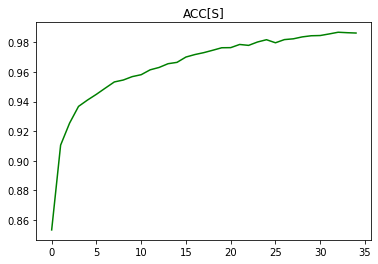

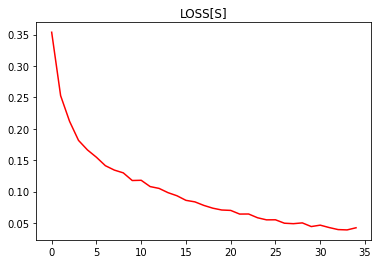

Training model [V]: on ['V_m_75_pd_10', 'V_i_100_pd_17']
Epoch 1/300
371/371 [==============================] - 17s 46ms/step - loss: 0.1222 - accuracy: 0.9628
Epoch 2/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0675 - accuracy: 0.9805
Epoch 3/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0510 - accuracy: 0.9843
Epoch 4/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0424 - accuracy: 0.9874
Epoch 5/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0359 - accuracy: 0.9891
Epoch 6/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0309 - accuracy: 0.9898
Epoch 7/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0272 - accuracy: 0.9915
Epoch 8/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0236 - accuracy: 0.9922
Epoch 9/300
371/371 [==============================] - 17s 45ms/step - loss: 0.0206 - accuracy: 0.9940
Epoch 10/300
371

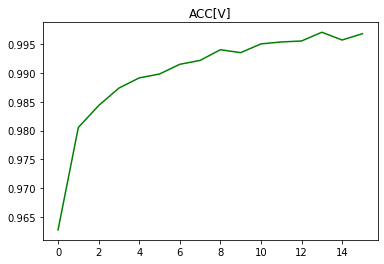

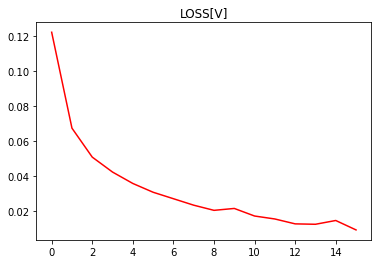

Saved Model Weights [S] at : /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_S22.h5
Saved Model Weights [V] at : /content/drive/My Drive/Masters/workdir/ecg_data/db_model/model_V22.h5


In [ ]:
expnos = 22
ds_listS = ['S_m_75_pd_1','S_s_150_pd_6']
ds_listV = ['V_m_75_pd_10','V_i_100_pd_17' ]

print('S-datasets:',ds_listS)
ds_strS = np.zeros((0,5),dtype='U10')
for ds_name in ds_listS:
    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
    ds_this = np.load(ds_path)
    print('loaded:',ds_this.shape, ds_path)
    ds_strS=np.vstack((ds_strS,ds_this))
print('S-beats:',ds_strS.shape )

print('V-datasets:',ds_listV)
ds_strV = np.zeros((0,5),dtype='U10')
for ds_name in ds_listV:
    ds_path = os.path.join(global_dsdir,ds_name+'.npy') 
    ds_this = np.load(ds_path)
    print('loaded:',ds_this.shape, ds_path)
    ds_strV=np.vstack((ds_strV,ds_this))
print('V-beats:',ds_strV.shape )

work_db = std_db_msi

#======================================================================
#======================================================================

timestamp_start = datetime.datetime.now()

ds_selectedS = load_beat_segment2(ds_strS, work_db, S_DP, supress_NR=False)
print('')
data_xS = ds_selectedS
data_yS = ds_strS[:,4].astype('int')
print('[S]:',data_xS.shape,data_yS.shape)

ds_selectedV = load_beat_segment2(ds_strV, work_db, V_DP,supress_NR=False)
print('')
data_xV = ds_selectedV
data_yV = ds_strV[:,4].astype('int')
print('[V]:',data_xV.shape,data_yV.shape)


timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))

#======================================================================
#======================================================================

modelS=get_modelCNN_2(False,S_DP.vdim)
# Start Training---------------------------------------------------------
timestamp_start = datetime.datetime.now()
print('Training model [S]:', 'on',ds_listS)
history = modelS.fit(
                    data_xS, data_yS,
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
# End Training---------------------------------------------------------

plt.figure('ACC')
plt.title('ACC[S]')
plt.plot(history.history['accuracy'],color='green')
plt.show()

plt.figure('LOSS')
plt.title('LOSS[S]')
plt.plot(history.history['loss'],color='red')
plt.show()

print('===============================')

modelV=get_modelCNN_2(False,V_DP.vdim)
# Start Training---------------------------------------------------------
timestamp_start = datetime.datetime.now()
print('Training model [V]:', 'on',ds_listV)
history = modelV.fit(
                    data_xV, data_yV,
                    #batch_size=1000,
                    epochs=300,
                    callbacks=cb_listr,
                    #validation_data=([alle_m.reshape((elen,timesteps,1)),alle_t],alle_l),
                    shuffle=True,
                    verbose=1)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))
# End Training---------------------------------------------------------

plt.figure('ACC')
plt.title('ACC[V]')
plt.plot(history.history['accuracy'],color='green')
plt.show()

plt.figure('LOSS')
plt.title('LOSS[V]')
plt.plot(history.history['loss'],color='red')
plt.show()

#======================================================================
#======================================================================

ds_modelS = 'model_S' + str(expnos)
# save this model
model_pathS = os.path.join(global_modeldir, ds_modelS+'.h5')
modelS.save_weights(model_pathS)
print('Saved Model Weights [S] at : '+ str(model_pathS))

ds_modelV = 'model_V'+ str(expnos)
# save this model
model_pathV = os.path.join(global_modeldir, ds_modelV+'.h5')
modelV.save_weights(model_pathV)
print('Saved Model Weights [V] at : '+ str(model_pathV))

# [ TESTING ]

### [ define testing functions ]

In [ ]:
def perform_record_test1(modelS, modelV, sel_rec, sbi, sel_NR_count, NR_statergy, TS_low, TS_high, shuffle, nr_supress, S_DP, V_DP):

    print('\n==============================================')
    print(sel_rec.name)
    print('==============================================')
    #<<----------------------------------------------- Select Normal Rhythm
    nr_indices = get_normal_selection_test(sbi, sel_NR_count,  NR_statergy, shuffle, TS_low, TS_high)
    nr_count = len(nr_indices)
    if nr_count!=sel_NR_count:
        print('WARNING: count NR mismatch.... using',nr_count)        

    if nr_count==0:
        print('ERROR: No NR beat ....skip')    
    else:
        #<<----------------------------------------------- Examine NR supress
        if nr_supress:
             #<<----------------------------------------------- NR is zero
            sig_NRS = np.zeros((nr_count,S_DP.vdim),dtype='float')
            sig_NRV = np.zeros((nr_count,V_DP.vdim),dtype='float')
        else:
            #<<----------------------------------------------- Extract Record NR
            sig_NRS = np.zeros((0,S_DP.vdim),dtype='float')
            if S_DP.input_type=='fix':
                for i in range(0,nr_count):
                    d_NR,_ = sbi.get_signal_data_fix_samples(nr_indices[i],S_DP.fix_left,S_DP.fix_right)
                    sig_NRS = np.vstack((sig_NRS,d_NR))
            elif S_DP.input_type=='var':
                for i in range(0,nr_count):
                    d_NR,dpk,_= sbi.get_signal_data_var(nr_indices[i])
                    d_NR = pad_or_truncate(d_NR,dpk,S_DP.fix_left,S_DP.fix_right,S_DP.pad_value,S_DP.suppress_peak_len)
                    sig_NRS = np.vstack((sig_NRS,d_NR))
            else:
                print('Invalid Input Type')

            sig_NRV = np.zeros((0,V_DP.vdim),dtype='float')
            if V_DP.input_type=='fix':
                for i in range(0,nr_count):
                    d_NR,_ = sbi.get_signal_data_fix_samples(nr_indices[i],V_DP.fix_left,V_DP.fix_right)
                    sig_NRV = np.vstack((sig_NRV,d_NR))
            elif V_DP.input_type=='var':
                for i in range(0,nr_count):
                    d_NR,dpk,_= sbi.get_signal_data_var(nr_indices[i])
                    d_NR = pad_or_truncate(d_NR,dpk,V_DP.fix_left,V_DP.fix_right,V_DP.pad_value,V_DP.suppress_peak_len)
                    sig_NRV = np.vstack((sig_NRV,d_NR))
            else:
                print('Invalid Input Type')

        #<<------------------------------------------------------------ generate record data S type
        ds_recS = np.zeros((0,S_DP.vdim*2))
        ds_labS = np.zeros(sbi.rp_count)
        nrc = 0
        if S_DP.input_type=='fix':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==S_Label:
                    ds_labS[i] = 1
                else:
                    ds_labS[i] = 0
                d_CR,_ = sbi.get_signal_data_fix_samples(i,S_DP.fix_left,S_DP.fix_right)
                d_NR = sig_NRS[nrc%nr_count]
                d_data = np.hstack((d_NR,d_CR))
                ds_recS = np.vstack((ds_recS,d_data))
                nrc+=1
        elif S_DP.input_type=='var':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==S_Label:
                    ds_labS[i] = 1
                else:
                    ds_labS[i] = 0
                d_CR,dpk,_= sbi.get_signal_data_var(i)
                d_CR = pad_or_truncate(d_CR,dpk,S_DP.fix_left,S_DP.fix_right,S_DP.pad_value,S_DP.suppress_peak_len)
                d_NR = sig_NRS[nrc%nr_count]
                d_data = np.hstack((d_NR,d_CR))
                ds_recS = np.vstack((ds_recS,d_data))
                nrc+=1
        else:
            print('Invalid Input Type')

        #<<------------------------------------------------------------ generate record data V type
        ds_recV = np.zeros((0,V_DP.vdim*2))
        ds_labV = np.zeros(sbi.rp_count)
        nrc = 0
        if V_DP.input_type=='fix':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==V_Label:
                    ds_labV[i] = 1
                else:
                    ds_labV[i] = 0
                d_CR,_ = sbi.get_signal_data_fix_samples(i,V_DP.fix_left,V_DP.fix_right)
                d_NR = sig_NRV[nrc%nr_count]
                d_data = np.hstack((d_NR,d_CR))
                ds_recV = np.vstack((ds_recV,d_data))
                nrc+=1
        elif V_DP.input_type=='var':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==V_Label:
                    ds_labV[i] = 1
                else:
                    ds_labV[i] = 0
                d_CR,dpk,_= sbi.get_signal_data_var(i)
                d_CR = pad_or_truncate(d_CR,dpk,V_DP.fix_left,V_DP.fix_right,V_DP.pad_value,V_DP.suppress_peak_len)
                d_NR = sig_NRV[nrc%nr_count]
                d_data = np.hstack((d_NR,d_CR))
                ds_recV = np.vstack((ds_recV,d_data))
                nrc+=1
        else:
            print('Invalid Input Type')

        #------------------------------------------------------------ format record data

        data_xS =  np.expand_dims(ds_recS,axis=-1)
        data_xV =  np.expand_dims(ds_recV,axis=-1)
        data_yS = ds_labS
        data_yV = ds_labV
        data_yA = np.logical_or(data_yS,data_yV).astype('int')
        data_yNotN = np.zeros(sbi.rp_count)
        data_yNotN[np.where(sbi.rli_curr!=N_Label)[0]]=1

        #------------------------------------------------------------ manual prediction S
        print('\n[S]:',data_xS.shape)
        predxS = modelS.predict( data_xS ) # - each row is a prediction of a sample
        pred_res_S = predxS.argmax(axis=1)
        conf_matrix_S = np.zeros((len(gS_LABELS),len(gS_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_S)):
            alabel = int(data_yS[i])
            plabel = pred_res_S[i]
            conf_matrix_S[alabel,plabel]+=1
        print('\tConfusion Matrix [S]')
        print(print_conf_matrix( conf_matrix_S,'', gS_LABELS)) 
        print_performance( get_performance(conf_matrix_S) ,gS_LABELS ) 

        #------------------------------------------------------------ manual prediction V
        print('\n[V]:' ,data_xV.shape)
        predxV = modelV.predict( data_xV ) # - each row is a prediction of a sample
        pred_res_V = predxV.argmax(axis=1)
        conf_matrix_V = np.zeros((len(gV_LABELS),len(gV_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_V)):
            alabel = int(data_yV[i])
            plabel = pred_res_V[i]
            conf_matrix_V[alabel,plabel]+=1
        print('\tConfusion Matrix [V]')
        print(print_conf_matrix( conf_matrix_V,'', gV_LABELS)) 
        print_performance( get_performance(conf_matrix_V) ,gV_LABELS ) 

        #------------------------------------------------------------ manual prediction Combined
        print('\n[Combined]')
        pred_res_A = np.logical_or(pred_res_S, pred_res_V).astype('int')
        conf_matrix_A = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_A)):
            alabel = int(data_yA[i])
            plabel = pred_res_A[i]
            conf_matrix_A[alabel,plabel]+=1
        print('\tConfusion Matrix [Combined]')
        print(print_conf_matrix( conf_matrix_A,'', gA_LABELS)) #logit('\t'+str(cmx))
        print_performance( get_performance(conf_matrix_A) ,gA_LABELS ) 

        #------------------------------------------------------------ manual prediction Not N
        print('\n[Overall]')
        conf_matrix_NA = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_A)):
            alabel = int(data_yNotN[i])
            plabel = pred_res_A[i]
            conf_matrix_NA[alabel,plabel]+=1
        print('\tConfusion Matrix [Overall]')
        print(print_conf_matrix( conf_matrix_NA,'', gA_LABELS)) #logit('\t'+str(cmx))
        print_performance( get_performance(conf_matrix_NA) ,gA_LABELS ) 

    return pred_res_S, pred_res_V, pred_res_A, conf_matrix_S, conf_matrix_V, conf_matrix_A, conf_matrix_NA

def perform_record_test2(modelS, modelV, sel_rec, sbi, sel_NR_count, NR_statergy, TS_low, TS_high, shuffle, nr_supress, S_DP, V_DP):

    print('\n==============================================')
    print(sel_rec.name)
    print('==============================================')
    #<<----------------------------------------------- Select Normal Rhythm
    nr_indices = get_normal_selection_test(sbi, sel_NR_count,  NR_statergy, shuffle, TS_low, TS_high)
    nr_count = len(nr_indices)
    if nr_count!=sel_NR_count:
        print('WARNING: count NR mismatch.... using',nr_count)        

    if nr_count==0:
        print('ERROR: No NR beat ....skip') 
        return [],[],[],[],[],[],[]
        pred_res_S, pred_res_V, pred_res_A, conf_matrix_S, conf_matrix_V, conf_matrix_A, conf_matrix_NA   
    else:
        #<<----------------------------------------------- Examine NR supress
        if nr_supress:
             #<<----------------------------------------------- NR is zero
            sig_NRS = np.zeros((nr_count,S_DP.vdim),dtype='float')
            sig_NRV = np.zeros((nr_count,V_DP.vdim),dtype='float')
        else:
            #<<----------------------------------------------- Extract Record NR
            sig_NRS = np.zeros((0,S_DP.vdim),dtype='float')
            if S_DP.input_type=='fix':
                for i in range(0,nr_count):
                    d_NR,_ = sbi.get_signal_data_fix_samples(nr_indices[i],S_DP.fix_left,S_DP.fix_right)
                    sig_NRS = np.vstack((sig_NRS,d_NR))
            elif S_DP.input_type=='var':
                for i in range(0,nr_count):
                    d_NR,dpk,_= sbi.get_signal_data_var(nr_indices[i])
                    d_NR = pad_or_truncate(d_NR,dpk,S_DP.fix_left,S_DP.fix_right,S_DP.pad_value,S_DP.suppress_peak_len)
                    sig_NRS = np.vstack((sig_NRS,d_NR))
            else:
                print('Invalid Input Type')

            sig_NRV = np.zeros((0,V_DP.vdim),dtype='float')
            if V_DP.input_type=='fix':
                for i in range(0,nr_count):
                    d_NR,_ = sbi.get_signal_data_fix_samples(nr_indices[i],V_DP.fix_left,V_DP.fix_right)
                    sig_NRV = np.vstack((sig_NRV,d_NR))
            elif V_DP.input_type=='var':
                for i in range(0,nr_count):
                    d_NR,dpk,_= sbi.get_signal_data_var(nr_indices[i])
                    d_NR = pad_or_truncate(d_NR,dpk,V_DP.fix_left,V_DP.fix_right,V_DP.pad_value,V_DP.suppress_peak_len)
                    sig_NRV = np.vstack((sig_NRV,d_NR))
            else:
                print('Invalid Input Type')

        #<<------------------------------------------------------------ generate record data S type
        ds_recS = np.zeros((0,S_DP.vdim,2))
        ds_labS = np.zeros(sbi.rp_count)
        nrc = 0
        if S_DP.input_type=='fix':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==S_Label:
                    ds_labS[i] = 1
                else:
                    ds_labS[i] = 0
                d_CR,_ = sbi.get_signal_data_fix_samples(i,S_DP.fix_left,S_DP.fix_right)
                d_NR = sig_NRS[nrc%nr_count]
                d_data = np.expand_dims(np.transpose(np.vstack((d_NR,d_CR))),axis=0)
                ds_recS = np.vstack((ds_recS,d_data))
                nrc+=1
        elif S_DP.input_type=='var':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==S_Label:
                    ds_labS[i] = 1
                else:
                    ds_labS[i] = 0
                d_CR,dpk,_= sbi.get_signal_data_var(i)
                d_CR = pad_or_truncate(d_CR,dpk,S_DP.fix_left,S_DP.fix_right,S_DP.pad_value,S_DP.suppress_peak_len)
                d_NR = sig_NRS[nrc%nr_count]
                d_data = np.expand_dims(np.transpose(np.vstack((d_NR,d_CR))),axis=0)
                ds_recS = np.vstack((ds_recS,d_data))
                nrc+=1
        else:
            print('Invalid Input Type')

        #<<------------------------------------------------------------ generate record data V type
        ds_recV = np.zeros((0,V_DP.vdim,2))
        ds_labV = np.zeros(sbi.rp_count)
        nrc = 0
        if V_DP.input_type=='fix':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==V_Label:
                    ds_labV[i] = 1
                else:
                    ds_labV[i] = 0
                d_CR,_ = sbi.get_signal_data_fix_samples(i,V_DP.fix_left,V_DP.fix_right)
                d_NR = sig_NRV[nrc%nr_count]
                d_data = np.expand_dims(np.transpose(np.vstack((d_NR,d_CR))),axis=0)
                ds_recV = np.vstack((ds_recV,d_data))
                nrc+=1
        elif V_DP.input_type=='var':
            for i in range(0,sbi.rp_count):
                if sbi.rli_curr[i]==V_Label:
                    ds_labV[i] = 1
                else:
                    ds_labV[i] = 0
                d_CR,dpk,_= sbi.get_signal_data_var(i)
                d_CR = pad_or_truncate(d_CR,dpk,V_DP.fix_left,V_DP.fix_right,V_DP.pad_value,V_DP.suppress_peak_len)
                d_NR = sig_NRV[nrc%nr_count]
                d_data = np.expand_dims(np.transpose(np.vstack((d_NR,d_CR))),axis=0)
                ds_recV = np.vstack((ds_recV,d_data))
                nrc+=1
        else:
            print('Invalid Input Type')

        #------------------------------------------------------------ format record data

        data_xS = ds_recS
        data_xV = ds_recV
        data_yS = ds_labS
        data_yV = ds_labV
        data_yA = np.logical_or(data_yS,data_yV).astype('int')
        data_yNotN = np.zeros(sbi.rp_count)
        data_yNotN[np.where(sbi.rli_curr!=N_Label)[0]]=1

        #------------------------------------------------------------ manual prediction S
        print('\n[S]:',data_xS.shape)
        predxS = modelS.predict( data_xS ) # - each row is a prediction of a sample
        pred_res_S = predxS.argmax(axis=1)
        conf_matrix_S = np.zeros((len(gS_LABELS),len(gS_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_S)):
            alabel = int(data_yS[i])
            plabel = pred_res_S[i]
            conf_matrix_S[alabel,plabel]+=1
        print('\tConfusion Matrix [S]')
        print(print_conf_matrix( conf_matrix_S,'', gS_LABELS)) 
        print_performance( get_performance(conf_matrix_S) ,gS_LABELS ) 

        #------------------------------------------------------------ manual prediction V
        print('\n[V]:' ,data_xV.shape)
        predxV = modelV.predict( data_xV ) # - each row is a prediction of a sample
        pred_res_V = predxV.argmax(axis=1)
        conf_matrix_V = np.zeros((len(gV_LABELS),len(gV_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_V)):
            alabel = int(data_yV[i])
            plabel = pred_res_V[i]
            conf_matrix_V[alabel,plabel]+=1
        print('\tConfusion Matrix [V]')
        print(print_conf_matrix( conf_matrix_V,'', gV_LABELS)) 
        print_performance( get_performance(conf_matrix_V) ,gV_LABELS ) 

        #------------------------------------------------------------ manual prediction Combined
        print('\n[Combined]')
        pred_res_A = np.logical_or(pred_res_S, pred_res_V).astype('int')
        conf_matrix_A = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_A)):
            alabel = int(data_yA[i])
            plabel = pred_res_A[i]
            conf_matrix_A[alabel,plabel]+=1
        print('\tConfusion Matrix [Combined]')
        print(print_conf_matrix( conf_matrix_A,'', gA_LABELS)) #logit('\t'+str(cmx))
        print_performance( get_performance(conf_matrix_A) ,gA_LABELS ) 

        #------------------------------------------------------------ manual prediction Not N
        print('\n[Overall]')
        conf_matrix_NA = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32')
        for i in range(0,len(pred_res_A)):
            alabel = int(data_yNotN[i])
            plabel = pred_res_A[i]
            conf_matrix_NA[alabel,plabel]+=1
        print('\tConfusion Matrix [Overall]')
        print(print_conf_matrix( conf_matrix_NA,'', gA_LABELS)) #logit('\t'+str(cmx))
        print_performance( get_performance(conf_matrix_NA) ,gA_LABELS ) 

    return pred_res_S, pred_res_V, pred_res_A, conf_matrix_S, conf_matrix_V, conf_matrix_A, conf_matrix_NA



## [ ~List models and datasets ]

In [ ]:
print(global_dsdir)
ls_ants = os.listdir(global_dsdir)
ls_ants=np.sort(ls_ants)
print('Available datasets ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')
print(global_modeldir)
ls_ants = os.listdir(global_modeldir)
ls_ants=np.sort(ls_ants)
print('Available Models ['+str(len(ls_ants))+']')
for ls_ant in ls_ants:
    print(ls_ant)
print('--------------------------')

/content/drive/My Drive/Masters/workdir/ecg_data/db_dataset
Available datasets [18]
S_i_100_pd_8.npy
S_i_150_pd_9.npy
S_i_75_pd_7.npy
S_m_100_pd_2.npy
S_m_150_pd_3.npy
S_m_75_pd_1.npy
S_s_100_pd_5.npy
S_s_150_pd_6.npy
S_s_75_pd_4.npy
V_i_100_pd_17.npy
V_i_150_pd_18.npy
V_i_75_pd_16.npy
V_m_100_pd_11.npy
V_m_150_pd_12.npy
V_m_75_pd_10.npy
V_s_100_pd_14.npy
V_s_150_pd_15.npy
V_s_75_pd_13.npy
--------------------------
/content/drive/My Drive/Masters/workdir/ecg_data/db_model
Available Models [44]
model_S1.h5
model_S10.h5
model_S11.h5
model_S12.h5
model_S13.h5
model_S14.h5
model_S15.h5
model_S16.h5
model_S17.h5
model_S18.h5
model_S19.h5
model_S2.h5
model_S20.h5
model_S21.h5
model_S22.h5
model_S3.h5
model_S4.h5
model_S5.h5
model_S6.h5
model_S7.h5
model_S8.h5
model_S9.h5
model_V1.h5
model_V10.h5
model_V11.h5
model_V12.h5
model_V13.h5
model_V14.h5
model_V15.h5
model_V16.h5
model_V17.h5
model_V18.h5
model_V19.h5
model_V2.h5
model_V20.h5
model_V21.h5
model_V22.h5
model_V3.h5
model_V4.h5
model_

## [ Load model ]

## [ Testing - Database ]

### [ perform testing 2_channel ]

In [ ]:

work_db = std_db_msi
ds_modelS = 'model_S11'       # SELECT MODEL WEIGHTS TO TEST UPON
ds_modelV = 'model_V21'       # SELECT MODEL WEIGHTS TO TEST UPON

model_pathS = os.path.join(global_modeldir, ds_modelS +'.h5')
modelS=get_modelCNN_2(False,S_DP.vdim)
modelS.load_weights(model_pathS)
print('Loaded Model weights '+ str(model_pathS))
##<----------------------------------------------
model_pathV = os.path.join(global_modeldir, ds_modelV+'.h5')
modelV=get_modelCNN_2(False,V_DP.vdim)
modelV.load_weights(model_pathV)
print('Loaded Model weights '+ str(model_pathV))
##<----------------------------------------------
##<----------------------------------------------
##<----------------------------------------------
sel_NR_count = 30
NR_statergy = 'pure'
shuffle=0
TS_low, TS_high = 0*60, 300*60
nr_supress=False

conf_matrix_gS = np.zeros((len(gS_LABELS),len(gS_LABELS)),dtype='int32') # confusion matrix S
conf_matrix_gV = np.zeros((len(gV_LABELS),len(gV_LABELS)),dtype='int32') # confusion matrix V
conf_matrix_gA = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32') # confusion matrix Combined
conf_matrix_gNA = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32') # confusion matrix Overall

pred_res_gS, pred_res_gV, pred_res_gA = [], [], []


print('Testing database:',work_db.keys())
print('NR_Statergy:', NR_statergy)
print('NR_Count:', sel_NR_count)
print('NR_TimeLimits:', TS_low, TS_high)

#<<----------------------------------------
timestamp_start = datetime.datetime.now()
#<<----------------------------------------
print('\n----------------------------------------')

for idb in work_db.keys():
    #<<--------------------
    sel_db = work_db[idb]
    for irec in sel_db.recs_tag:
        #<<--------------------
        sel_rec = sel_db.get_record(irec)
        print('\n==============================================')
        #print(sel_rec.name)
        sbi = sel_rec.read_binfo()
        prS,prV,prA,cmS,cmV,cmA,cmNA = perform_record_test2(modelS, modelV, sel_rec, sbi, sel_NR_count, NR_statergy, TS_low, TS_high, shuffle, nr_supress, S_DP, V_DP)

        if len(cmS)!=0 and len(cmV)!=0 and len(cmA)!=0 and len(cmNA)!=0:
            conf_matrix_gS += cmS
            conf_matrix_gV += cmV
            conf_matrix_gA += cmA
            conf_matrix_gNA += cmNA
    # end loop
print('\n==============================================')
print('\tGlobal Confusion Matrix [S]')
print(print_conf_matrix( conf_matrix_gS,'', gS_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gS) ,gS_LABELS ) 
print('\n==============================================')
print('\tGlobal Confusion Matrix [V]')
print(print_conf_matrix( conf_matrix_gV,'', gV_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gV) ,gV_LABELS ) 
print('\n==============================================')
print('\tGlobal Confusion Matrix [Combined]')
print(print_conf_matrix( conf_matrix_gA,'', gA_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gA) ,gA_LABELS ) 
print('\n==============================================')
print('\tGlobal Confusion Matrix [Overall]')
print(print_conf_matrix( conf_matrix_gNA,'', gA_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gNA) ,gA_LABELS ) 
#------------------------------------------------------------
print('\n==============================================')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

Streaming output truncated to the last 5000 lines.

[S]: (2416, 384, 2)
	Confusion Matrix [S]
A\P	N	S
N	1658	741
S	3	14

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.69	1.0	0.69	0.82
S	0.69	0.02	0.82	0.69

[V]: (2416, 384, 2)
	Confusion Matrix [V]
A\P	N	V
N	1649	40
V	0	727

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.98	1.0	0.98	1.0
V	0.98	0.95	1.0	0.98

[Combined]
	Confusion Matrix [Combined]
A\P	N	A
N	1620	52
A	3	741

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.98	1.0	0.97	1.0
A	0.98	0.93	1.0	0.97

[Overall]
	Confusion Matrix [Overall]
A\P	N	A
N	1620	52
A	3	741

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.98	1.0	0.97	1.0
A	0.98	0.93	1.0	0.97


svdb_866

[S]: (2664, 384, 2)
	Confusion Matrix [S]
A\P	N	S
N	1800	697
S	12	155

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.73	0.99	0.72	0.93
S	0.73	0.18	0.93	0.72

[V]: (2664, 384, 2)
	Confusion Matrix [V]
A\P	N	V
N	97	2120
V	49	398

Performance for 2 classes
Class	ACC	PRE	SEN	SPF
N	0.19	0.66	0.04	0.89
V

## [ Testing - Record ]

### [ select record ]

In [ ]:
sel_db = std_mitdb
sel_rec = sel_db.get_record('223') # I54
ds_name = sel_rec.name
#<<-----------------------------------------------
sbi = sel_rec.read_binfo()
sbi.map_ants2int(g_STD_MAP)
sel_signal = sel_rec.read_data(g_SIG2)
print(sel_rec.name)

### [ perform testing 1_channel ]

In [ ]:
sel_NR_count = 10
NR_statergy = 'pure'
shuffle=0
TS_low, TS_high = 0*60, 5*60
nr_supress=False
#<<-----------------------------------------------
print('Testing record:',sel_rec.name)
print('NR_Statergy:', NR_statergy)
print('NR_Count:', sel_NR_count)
print('NR_TimeLimits:', TS_low, TS_high)
#<<-----------------------------------------------
timestamp_start = datetime.datetime.now()
#<<-----------------------------------------------
prS,prV,prA,cmS,cmV,cmA,cmNA =  perform_record_test1(modelS, modelV, sel_rec, sbi, sel_NR_count, NR_statergy, TS_low, TS_high, shuffle, nr_supress, S_DP, V_DP)
#<<-----------------------------------------------
timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))
#<<-----------------------------------------------


### [ perform testing 2_channel  ]

In [ ]:
sel_NR_count = 10
NR_statergy = 'pure'
shuffle=0
TS_low, TS_high = 0*60, 5*60
nr_supress=False
#<<-----------------------------------------------
print('Testing record:',sel_rec.name)
print('NR_Statergy:', NR_statergy)
print('NR_Count:', sel_NR_count)
print('NR_TimeLimits:', TS_low, TS_high)
#<<-----------------------------------------------
timestamp_start = datetime.datetime.now()
#<<-----------------------------------------------
prS,prV,prA,cmS,cmV,cmA,cmNA =  perform_record_test2(modelS, modelV, sel_rec, sbi, sel_NR_count, NR_statergy, TS_low, TS_high, shuffle, nr_supress, S_DP, V_DP) 
#<<-----------------------------------------------
timestamp_dur = datetime.datetime.now() - timestamp_start
print('\nElapsed time = ' + str(timestamp_dur))

In [ ]:
print(np.where((data_yS==1)&(cmx2_localS!=1))[0])
print(cmx2_localV[np.where((data_yS==1)&(cmx2_localS!=1))[0]])
print(np.where((data_yA==1)&(cmx2_localA!=1))[0])

### [ plot predictions ]

In [ ]:
#<<--------------------------------------------------------------------
x_scale = 25 * 0.0393701 # mm/sec -> inches/sec
y_scale = 10 * 0.0393701 # mm/mV -> inches/sec
y_low = -2.5
y_high = 3.5
#------------------------------------------------------------

ff=210
tt=ff+17
sgv,_,_=plot_ecg_segment(sbi, sel_signal, 
                 ff, tt, 
                 x_scale, y_scale, y_low, y_high,
                 -2, False, 
                 [cmx2_localS,cmx2_localV,cmx2_localA], 
                 [data_yS,data_yV,data_yA], data_yNotN,
                 ['tab:red','tab:blue', 'tab:orange'] ,
                 ['$S$','$V$','$A$'],
                 gain=1)




---

EOE

---



# [ ARCH ]

achived old code

### [ 1_channel data ]

In [ ]:
timestamp_start = datetime.datetime.now()
ds_selected = load_beat_segment(ds_str, work_db, data_param,supress_NR=True)

timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))

print('')
data_x = np.expand_dims(ds_selected,axis=-1)
data_y = ds_str[:,4].astype('int')
print(data_x.shape,data_y.shape)

In [ ]:
ds_sample = random.randint(0,len(data_y)-1)
print('Sample',ds_sample,'of',len(data_y))
print(ds_str[ds_sample])
plt.figure(figsize=(12,6))
plt.ylim(-2.5,3.5)
plt.xlim(0,data_param.vdim*2)
plt.plot(data_x[ds_sample],color='tab:green')
plt.vlines(data_param.fix_left,-2.5,3.5,linewidth=0.3,color='black')
plt.vlines(data_param.vdim,-2.5,3.5,linewidth=0.3,color='black')
plt.vlines(data_param.vdim+data_param.fix_left,-2.5,3.5,linewidth=0.3,color='black')
plt.tight_layout()

# plot 2c

In [ ]:
ds_sampleS = random.randint(0,len(ds_selectedS)-1)
print('Sample',ds_sampleS,'of',len(ds_selectedS))
print(ds_strS[ds_sampleS])
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].set_ylim(-2.5,3.5)
ax[0].plot(ds_selectedS[ds_sampleS][:,0],color='tab:green')
ax[0].vlines(S_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
ax[1].set_ylim(-2.5,3.5)
ax[1].plot(ds_selectedS[ds_sampleS][:,1],color='tab:red')
ax[1].vlines(S_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')

ds_sampleV = random.randint(0,len(ds_selectedV)-1)
print('Sample',ds_sampleV,'of',len(ds_selectedV))
print(ds_strV[ds_sampleV])
fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
ax[0].set_ylim(-2.5,3.5)
ax[0].plot(ds_selectedV[ds_sampleV][:,0],color='tab:green')
ax[0].vlines(V_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')
ax[1].set_ylim(-2.5,3.5)
ax[1].plot(ds_selectedV[ds_sampleV][:,1],color='tab:blue')
ax[1].vlines(V_DP.fix_left,-2.5,3.5,linewidth=0.3,color='black')



---



### [ perform testing 1_channel ]

In [ ]:
sel_NR_count = 4
NR_statergy = 'pure'
shuffle=0
TS_low, TS_high = 0*60, 5*60
nr_supress=False

conf_matrix_gS = np.zeros((len(gS_LABELS),len(gS_LABELS)),dtype='int32') # confusion matrix S
conf_matrix_gV = np.zeros((len(gV_LABELS),len(gV_LABELS)),dtype='int32') # confusion matrix V
conf_matrix_gA = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32') # confusion matrix Combined
conf_matrix_gNA = np.zeros((len(gA_LABELS),len(gA_LABELS)),dtype='int32') # confusion matrix Overall

pred_res_gS, pred_res_gV, pred_res_gA = [], [], []


print('Testing database:',work_db.keys())
print('NR_Statergy:', use_NRstatergy)
print('NR_Count:', sel_NR_count)
print('NR_TimeLimits:', TS_low, TS_high)

#<<----------------------------------------
timestamp_start = datetime.datetime.now()
#<<----------------------------------------
print('\n----------------------------------------')

for idb in work_db.keys():
    #<<--------------------
    sel_db = work_db[idb]
    for irec in sel_db.recs_tag:
        #<<--------------------
        sel_rec = sel_db.get_record(irec)
        print('\n==============================================')
        #print(sel_rec.name)
        sbi = sel_rec.read_binfo()
        prS,prV,prA,cmS,cmV,cmA,cmNA = perform_record_test1(modelS, modelV, sel_rec, sbi, sel_NR_count, NR_statergy, TS_low, TS_high, shuffle, nr_supress, S_DP, V_DP)

        conf_matrix_gS += cmS
        conf_matrix_gV += cmV
        conf_matrix_gA += cmA
        conf_matrix_gNA += cmNA
    # end loop
print('\n==============================================')
print('\tGlobal Confusion Matrix [S]')
print(print_conf_matrix( conf_matrix_gS,'', gS_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gS) ,gS_LABELS ) 
print('\n==============================================')
print('\tGlobal Confusion Matrix [V]')
print(print_conf_matrix( conf_matrix_gV,'', gV_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gV) ,gV_LABELS ) 
print('\n==============================================')
print('\tGlobal Confusion Matrix [Combined]')
print(print_conf_matrix( conf_matrix_gA,'', gA_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gA) ,gA_LABELS ) 
print('\n==============================================')
print('\tGlobal Confusion Matrix [Overall]')
print(print_conf_matrix( conf_matrix_gNA,'', gA_LABELS)) #logit('\t'+str(cmx))
print_performance( get_performance(conf_matrix_gNA) ,gA_LABELS ) 
#------------------------------------------------------------
print('\n==============================================')
timestamp_dur = datetime.datetime.now() - timestamp_start
print('Elapsed time = ' + str(timestamp_dur))